In [71]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
from skimage.transform import rotate 

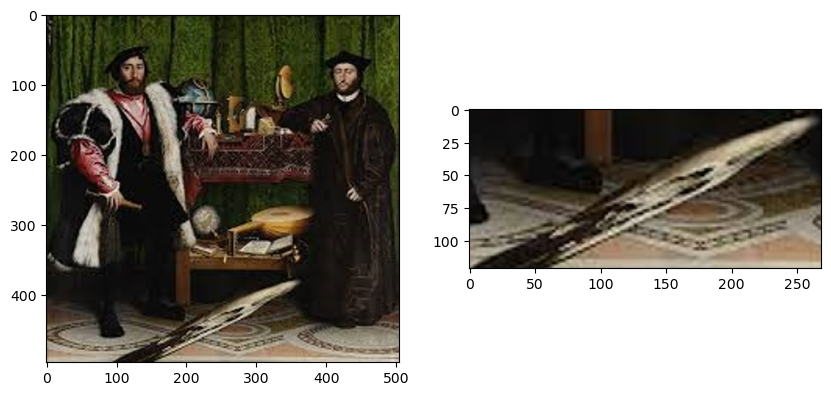

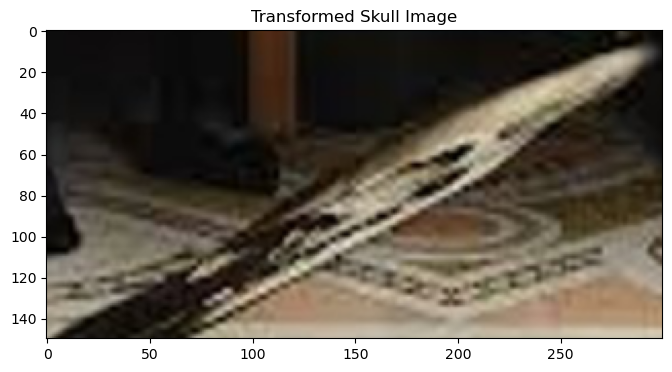

In [177]:
a = io.imread("./source/ambassadors.jpg")
skull = a[374:495, 97:366]

# Display the original image and the extracted skull region to confirm extraction
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(a)
ax2.imshow(skull)
plt.show()

# Now, let's apply a perspective transformation to correct the skull

# Convert the skull region to an OpenCV-compatible format (BGR)
skull_cv = cv2.cvtColor(skull, cv2.COLOR_RGB2BGR)

# Define the source and destination points for perspective transformation
src_pts = np.float32([[0, 0], [skull.shape[1] - 1, 0], [0, skull.shape[0] - 1], [skull.shape[1] - 1, skull.shape[0] - 1]])
dst_pts = np.float32([[0, 0], [300, 0], [0, 150], [300, 150]])  # Adjust destination size to match reference

# Compute the transformation matrix
matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Apply the perspective transformation
warped_skull = cv2.warpPerspective(skull_cv, matrix, (300, 150))

# Convert back to RGB for displaying with matplotlib
warped_skull_rgb = cv2.cvtColor(warped_skull, cv2.COLOR_BGR2RGB)

# Display the transformed skull
plt.figure(figsize=(8, 4))
plt.imshow(warped_skull_rgb)
# plt.axis("off")""
plt.title("Transformed Skull Image")
# plt.savefig('./source/output.png')
plt.show()

In [199]:
def unwarp(img, src, dst, testing, angle):
    h, w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (w, h), flags = cv2.INTER_LINEAR)
    if testing:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
        f.subplots_adjust(hspace=.2, wspace=.05)
        ax1.imshow(img, cmap='gray')
        x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
        y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
        ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
        # image_rotated = cv2.flip(img, 1)
        image_rotated = rotate(warped, angle)
        ax1.set_ylim([h, 0])
        ax1.set_xlim([0, w])
        ax1.set_title('Original Image', fontsize=20)

        ax2.imshow(image_rotated, cmap='gray')
        ax2.set_title('Distortion Correction Result', fontsize=20)
        plt.show()
    else:
        return warped, M

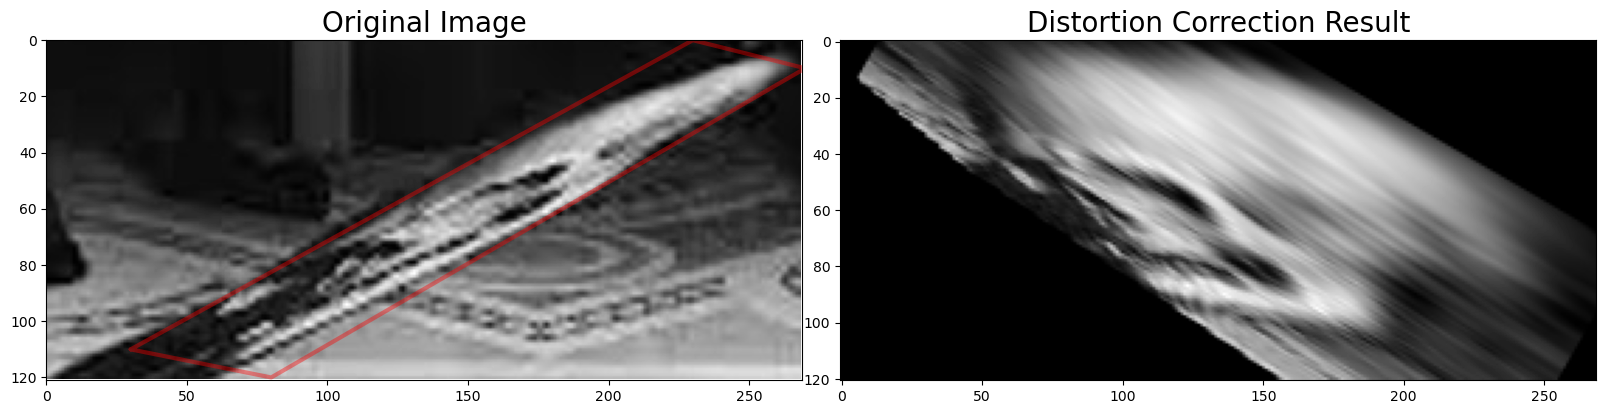

In [201]:
pointLoc = np.float32([(30, 110), (80, 120), (230, 0), (270, 10)])       # 左下、右下、左上、右上

pointLocNEW =np.float32([(60, 90) ,(170, 100), (0, 10), (270, 0)])

unwarp(skull, pointLoc, pointLocNEW, True, -30)